## Introduction
In this notebook we will demonstrates how to apply post-training quantization on a keras model with BigDL-Nano.


### Prepare Environment
Before you start with Apis delivered by bigdl-nano, you have to make sure BigDL-Nano is correctly installed for TensorFlow. If not, please follow [this](../../../../../docs/readthedocs/source/doc/Nano/Overview/nano.md) to set up your environment.<br>



By default, [Intel Neural Compressor](https://github.com/intel/neural-compressor) is not installed with BigDL-Nano. So if you determine to use it as your quantization backend, you'll need to install it first:
```bash
pip install neural-compressor==1.11.0
```


BigDL-Nano provides several APIs which can help users easily apply optimizations on inference pipelines to improve latency and throughput. The Keras Model(`bigdl.nano.tf.keras.Model`) and Sequential(`bigdl.nano.tf.keras.Sequential`) provides the APIs for all optimizations you need for inference.


In [1]:
from bigdl.nano.tf.keras import Model, Sequential

### Loading Data
Here we load data from tensorflow_datasets. The [Imagenette](https://github.com/fastai/imagenette) is a subset of 10 easily classified classes from the Imagenet dataset.


In [7]:
import tensorflow_datasets as tfds
DATANAME = 'imagenette/320px-v2'
(train_ds, test_ds), info = tfds.load(DATANAME, data_dir='../data/',
                                     split=['train', 'validation'],
                                     with_info=True,
                                     as_supervised=True)

#### Visualizing the Data
The following code shows the first 6 images with their labels.

,image,label
0,,2 (n02979186)
1,,6 (n03417042)
2,,7 (n03425413)
3,,3 (n03000684)
4,,4 (n03028079)
5,,5 (n03394916)

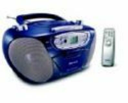
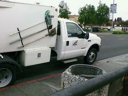
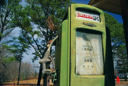
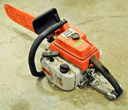
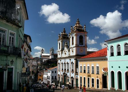
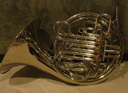

In [4]:
tfds.as_dataframe(train_ds.take(6), info)

#### Prepare Inputs
Here we resize the input image to uniform `IMG_SIZE` and the labels are put into one_hot.

In [8]:
# Create a Dataset that includes only 1/num_shards of full dataset.
from operator import index
import os
num_shards = int(os.environ.get('NUM_SHARDS', 1))
train_ds = train_ds.shard(num_shards, index=0)
test_ds = test_ds.shard(num_shards, index=0)

import tensorflow as tf
img_size = 224
num_classes = info.features['label'].num_classes
train_ds = train_ds.map(lambda img, label: (tf.image.resize(img, (img_size, img_size)), tf.one_hot(label, num_classes))).batch(32)
test_ds = test_ds.map(lambda img, label: (tf.image.resize(img, (img_size, img_size)), tf.one_hot(label, num_classes))).batch(32)


### Build Model
Here we initialize the ResNet50 from `tf.keras.applications` with pre-trained ImageNet weights.

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.cast(inputs, tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(x)
backbone = ResNet50(weights='imagenet')
backbone.trainable = False
x = backbone(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])



In [5]:
model.fit(train_ds, epochs=1)

# testing
from time import time
start = time()
his = model.evaluate(test_ds)
fp32_infer_time = time() - start

296/296 [==============================] - 52s 168ms/step - loss: 0.5111 - accuracy: 0.9658


### Quantization with Intel Neural Compressor
[`Model.quantize()`](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/Nano/tensorflow.html#bigdl.nano.tf.keras.Model) return a Keras module with desired precision and accuracy. Taking Resnet50 as an example, you can add quantization as below.

In [7]:
from tensorflow.keras.metrics import CategoricalAccuracy
q_model = model.quantize(x=test_ds,
                         metric=CategoricalAccuracy(),
                         tuning_strategy='basic'
                         )

2022-07-24 23:13:08 [WARNING] Override the value of `metric` field defined in yaml file as user defines the value of `metric` attribute by code.
2022-07-24 23:13:09.188297: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-24 23:13:09.188479: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-07-24 23:13:09.204934: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1149] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.006ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.

2022-07-24 23:13:10.769523: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-24 23:13:10.769664: I tensorflow/core/grap

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


2022-07-24 23:13:19 [WARNING] From /root/anaconda3/envs/nanoTensorflow/lib/python3.7/site-packages/neural_compressor/adaptor/tf_utils/util.py:322: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-07-24 23:13:21 [INFO] Pass StripUnusedNodesOptimizer elapsed time: 2428.79 ms
2022-07-24 23:13:21 [INFO] Pass GraphCseOptimizer elapsed time: 611.77 ms
2022-07-24 23:13:23 [INFO] Pass FoldBatchNormNodesOptimizer elapsed time: 1571.7 ms
2022-07-24 23:13:23 [INFO] Pass UpdateEnterOptimizer elapsed time: 59.61 ms
2022-07-24 23:13:23 [INFO] Pass ConvertLeakyReluOptimizer elapsed time: 62.76 ms
2022-07-24 23:13:23 [INFO] Pass ConvertAddToBiasAddOptimizer elapsed time: 61.43 ms
2022-07-24 23:13:23 [INFO] Pass FuseTransposeReshapeOptimizer elapsed time: 64.46 ms
2022-07-24 23:13:23 [INFO] Pass FuseConvWithMathOptimizer elapsed time: 62.13 ms
2022-0

In [9]:
from time import time

# run simple prediction
m1 = CategoricalAccuracy()
start = time()
for img, label in test_ds:
    m1.update_state(label, q_model(img))
infer_time_int8 = time() - start

### Summary

In [25]:
template = """
|    Precision    |    Infer Time(s)  | Accuracy(%) |
|      fp32       |       {:5.2f}       |    {:5.2f}    |
|      int8       |       {:5.2f}       |    {:5.2f}    |
| Improvement(%)  |       {:5.2f}       |    {:5.2f}    |
"""
summary = template.format(
    fp32_infer_time, his[1] * 100,
    infer_time_int8, m1.result().numpy() * 100,
    (1 - infer_time_int8/fp32_infer_time) * 100,  (m1.result().numpy()/his[1] - 1) * 100
)
print(summary)


|    Precision    |    Infer Time(s)  | Accuracy(%) |
|      fp32       |       21.37       |    97.94    |
|      int8       |        5.21       |    97.83    |
| Improvement(%)  |       75.63       |    -0.10    |

